#  Unsupervised learning addition model

Author: S. Menary [sbmenary@gmail.com]

Date: 5/4/2023  (last update: 9/4/2023)

Overview: Train a `sequence -> sequence` model where the input sequence is a text representation of a simple sum $A \pm B$ for integers $A,B\in\mathbb{Z}\left([-N,~N]\right)$ for some maximum-amplitude $N$, and the output is a text representation of the answer. Since the output is a numerical value, the loss function is a sparse categorical entropy

---

## 1. Set up program

###  Import

All imports go here at the top of the notebook

In [1]:
##=========================##
##   All imports go here   ##
##=========================##

##  Import entire python stdlib packages
import logging, math, os, pickle, random, sys, time

##  Import entire pypi packages
import numpy      as np
import tensorflow as tf

##  Import individual modules/objects from python stdlib packages
from pathlib import Path

##  Import individual modules/objects from pypi packages
from tensorflow.keras.callbacks  import EarlyStopping, ModelCheckpoint

##  Add directory above this to system path to expose mathsformer package location
sys.path.append("/".join(os.getcwd().split("/")[:-1]))

##  Import individual modules/objects from local packages
from mathsformer.data        import train_val_test_split, TokenTransform
from mathsformer.tf_objects  import (create_custom_objects_dict, masked_accuracy, masked_sparse_categorical_crossentropy, 
                                     MetricRecord, LayerActivationRecord, LayerWeightsRecord, LoggerCallback)
from mathsformer.transformer import create_text_to_text_model, Transformer_Text_to_Text
from mathsformer.utils       import create_working_directory, fancy_message, initialise_program


### Configuation

Set global configuration variables

In [2]:
##===================##
##   Global config   ##
##===================##

##  Create dictionary of config values
##  -  config values to be set here and never changed!
##  -  use nested dictionary as a proxy for namespacing
global_config = {
    "base_seed"         : -1,
    "working_directory" : "unsupervised_learning_addition_model_[tag]_[date]",
    "tag"               : "baseline",
    "log_lvl_iostream"  : logging.INFO,
    "log_lvl_fstream"   : logging.DEBUG,
    "data" : {
        "max_int"           : 999,
        "characters"        : ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-'],
        "mask_char"         : 'M',
        "seq_start_char"    : 'B',
        "seq_end_char"      : 'E',
        "negative_char"     : 'N',
        "dtype"             : "int32",
        "test_split_idx"    : 0.02,
        "val_split_idx"     : 0.04,
    },
    "model" : {
        "load_pretrained_model" : "",
        "name"                  : "mathsformer_LLM",
        "dtype"                 : "float32",
        "dropout"               : 0.1,
        "learning_rate"         : 3e-4,
        "positional_encoding" : {
            "num_freqs"         : 16,
            "min_period"        : 4,
            "max_period"        : 300,
        },
        "ndim_embedding"        : 32,
        "comb_type"             : 'average',
        "pre_encoder" : {
            "num_layers"        : -1,
            "ndim"              : 128,
            "skip_connect"      : True,
        },
        "pre_decoder" : {
            "num_layers"        : -1,
            "ndim"              : 128,
            "skip_connect"      : True,
        },
        "encoder" : {
            "num_blocks"        : 3,
            "num_heads"         : 6,
            "ndim"              : 32,
            "ndim_att_hidden"   : 32,
            "ndim_ff_hidden"    : 64,
        },
        "decoder" : {
            "num_blocks"        : 3,
            "num_heads"         : 6,
            "ndim"              : 32,
            "ndim_att_hidden"   : 32,
            "ndim_ff_hidden"    : 64,
        },
        "post_decoder" : {
            "num_layers"        : 2,
            "ndim"              : 128,
        },
    },
    "training" : {
        "train"                   : True,
        "max_epochs"              : 10000,
        "batch_size"              : 32,
        "early_stopping"          : False,
        "early_stopping_patience" : 5,
        "layer_activation_record_batch_frequency" : 5000, 
        "layer_activation_record_max_datapoints"  : 32, 
        "layer_weights_record_batch_frequency" : 5000, 
        "layer_weights_record_recursive"       : True, 
        "loss_record_batch_frequency" : 5000, 
        "loss_record_max_datapoints"  : 256, 
        "loss_record_num_bootstrap"   : 20,
        "loss_record_plot_frequency"  : 20000, 
        "loss_record_plot_after_epoch": True, 
    },
    "evaluate" : {
        "num_print" : 20,
    },
}


##  Report success
print(fancy_message(f"Created global_config"))


===   Created global_config   ===


###  Validate config

Look for some obvious confguration errors. WARNING: This is not an exhaustive search and can't be replied upon to catch all misconfigurations!

In [3]:
##===============================##
##   Global config - continued   ##
##===============================##

def validate_config(config) :
    """Raise exceptions in the case of program misconfigurations"""
    mask_char      = global_config["data"]["mask_char"]
    seq_start_char = global_config["data"]["seq_start_char"]
    seq_end_char   = global_config["data"]["seq_end_char"]
    negative_char  = global_config["data"]["negative_char"]
    char_tokens    = global_config["data"]["characters"]
    
    ##  Check that only single character tokens are provided
    for char_token in char_tokens :
        if len(char_token) == 1 : continue
        raise ValueError(f"All character tokens must be single characters but '{char_tokens}' found")
        
    ##  Check mask character is provided
    if len(mask_char) != 1 :
        raise ValueError(f"Mask character must be a single character but '{mask_char}' provided")
        
    ##  Check mask character in character list
    if mask_char not in char_tokens :
        raise ValueError(f"Mask character '{mask_char}' not found in character list: {char_tokens}")
    
    ##  Check that mask character is first in char_tokens list (ensures it's assigned a token of 0)
    if char_tokens[0] != mask_char :
        raise ValueError(f"Mask character '{mask_char}' must be the first in the char_tokens list provided, "
                        +f"instead found list: {char_tokens}")
        
    ##  Check seq_start_char character is provided
    if len(seq_start_char) != 1 :
        raise ValueError(f"Sequence start character must be a single character but '{seq_start_char}' provided")
        
    ##  Check seq_start_char character in character list
    if seq_start_char not in char_tokens :
        raise ValueError(f"Sequence start character '{seq_start_char}' not found in character list: {char_tokens}")
        
    ##  Check seq_end_char character is provided
    if len(seq_end_char) != 1 :
        raise ValueError(f"Sequence end character must be a single character but '{seq_end_char}' provided")
        
    ##  Check seq_start_char character in character list
    if seq_end_char not in char_tokens :
        raise ValueError(f"Sequence end character '{seq_end_char}' not found in character list: {char_tokens}")
        
    ##  Check negative_char character is provided
    if len(negative_char) != 1 :
        raise ValueError(f"Negative symbol character must be a single character but '{negative_char}' provided")
        
    ##  Check negative_char character in character list
    if negative_char not in char_tokens :
        raise ValueError(f"Negative symbol character '{negative_char}' not found in character list: {char_tokens}")
        
    ##  If here then config validated correctly
    print(fancy_message("Config successfully validated"))
    
validate_config(global_config)

===   Config successfully validated   ===


##  2. Set up environment

- Create working directory
- Create logger
- Log package versions for reproducibility
- Log config values for reproducibility
- Set random seeds for reproducibility


In [4]:
##==============================##
##   Create working directory   ##
##==============================##

##  Report success
working_dir, logger, base_seed, np_seed, tf_seed = initialise_program(
    "unsupervised_learning_model notebook", 
    working_dir       = global_config["working_directory"], 
    global_config     = global_config,
    log_lvl_iostream  = global_config["log_lvl_iostream"],
    log_lvl_fstream   = global_config["log_lvl_fstream" ],
)


===   Working directory created at unsupervised_learning_addition_model_baseline_2023_04_13_v2   ===
   INFO initialise_logging: Begin logging on 2023-04-13 at 22:30:16
   INFO initialise_program: Program description: unsupervised_learning_model notebook
   INFO initialise_program: Working directory: unsupervised_learning_addition_model_baseline_2023_04_13_v2
   INFO log_versions: ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO log_versions:                                              PACKAGE  |  VERSION
   INFO log_versions: ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO log_versions:                                               Python  |  3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]
   INFO log_versions:                                              IPyt

   INFO log_versions:                                 platformdirs.version  |  2.6.0
   INFO log_versions:                                       prompt_toolkit  |  3.0.36
   INFO log_versions:                                               psutil  |  5.9.4
   INFO log_versions:                                           ptyprocess  |  0.7.0
   INFO log_versions:                                            pure_eval  |  0.2.2
   INFO log_versions:                                    pure_eval.version  |  0.2.2
   INFO log_versions:                                               pydevd  |  2.9.1
   INFO log_versions:                                             pygments  |  2.13.0
   INFO log_versions:                                            pyparsing  |  3.0.9
   INFO log_versions:                                                   re  |  2.2.1
   INFO log_versions:                                             requests  |  2.28.1
   INFO log_versions:                                 requests

   INFO initialise_program: Registered global config value model > positional_encoding > max_period: 300
   INFO initialise_program: Registered global config value model > ndim_embedding: 32
   INFO initialise_program: Registered global config value model > comb_type: average
   INFO initialise_program: Registered global config value model > pre_encoder > num_layers: -1
   INFO initialise_program: Registered global config value model > pre_encoder > ndim: 128
   INFO initialise_program: Registered global config value model > pre_encoder > skip_connect: True
   INFO initialise_program: Registered global config value model > pre_decoder > num_layers: -1
   INFO initialise_program: Registered global config value model > pre_decoder > ndim: 128
   INFO initialise_program: Registered global config value model > pre_decoder > skip_connect: True
   INFO initialise_program: Registered global config value model > encoder > num_blocks: 3
   INFO initialise_program: Registered global config value

##  3. Create training data

###  Generate string-string pairs

In [5]:
##===================================##
##   Define data wrangling methods   ##
##===================================##

def generate_raw_dataset(max_int:int=999, include_neg:bool=True, shuffle:bool=True, negative_char:str='N') :
    '''
    Create dataset where input is str of "A+B" or "A-B", and output is str containing the answer
    A and B are positive or negative integers with maximum amplitude given
    '''
    logger.info(f"generate_raw_dataset(): called with max_int={max_int:,}, include_neg={include_neg}, shuffle={shuffle}")
    start_time = time.time()
    if include_neg : singles = np.arange(-max_int, max_int+1, dtype=np.int32) 
    else           : singles = np.arange(0       , max_int+1, dtype=np.int32)
    pairs   = np.array([[(x,y) for x in singles] for y in singles])
    pairs   = np.concatenate(pairs)
    summed  = pairs[:,0] + pairs[:,1]
    minus   = pairs[:,0] - pairs[:,1]
    dataset = []
    for (i1, i2), s, m in zip(pairs, summed, minus) :
        i1, i2 = f"{i1}".replace("-",negative_char), f"{i2}".replace("-",negative_char)
        s , m  = f"{s }".replace("-",negative_char), f"{m }".replace("-",negative_char)
        dataset.append((f"{i1}+{i2}", f"{s}"))
        dataset.append((f"{i1}-{i2}", f"{m}"))
    np.random.shuffle(dataset)
    logger.info(f"generate_raw_dataset(): created dataset with length {len(dataset):,} in {time.time()-start_time:.1f}s")
    return dataset


###   Process strings into fixed-length tokenised dataset with position indices

In [6]:
##===================================##
##   Create dataset of raw strings   ##
##===================================##

raw_dataset = generate_raw_dataset(global_config["data"]["max_int"], 
                                   negative_char=global_config["data"]["negative_char"])


   INFO generate_raw_dataset: generate_raw_dataset(): called with max_int=999, include_neg=True, shuffle=True
   INFO generate_raw_dataset: generate_raw_dataset(): created dataset with length 7,992,002 in 6.7s


In [7]:
##======================================================##
##   Create TokenTransform object using config values   ##
##======================================================##

token_transform = TokenTransform.from_dictionary(global_config["data"])
token_transform.summary(print_fn=logger.info)


   INFO summary: TokenTransform of dtype int32 with 16 characters: ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-']
   INFO summary: Special characters are seq_start_char (B), seq_end_char (E), mask_char (M)
   INFO summary: Tokeniser dictionary is {'M': 0, 'B': 1, 'E': 2, 'N': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '+': 14, '-': 15}
   INFO summary: Detokeniser dictionary is {0: 'M', 1: 'B', 2: 'E', 3: 'N', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '+', 15: '-'}


In [8]:
##=============================================##
##   Convert raw data to tokenised sequences   ##
##=============================================##

start_time = time.time()
data_X     = token_transform.strings_to_tensor([x[0] for x in raw_dataset])
data_Y     = token_transform.strings_to_tensor([x[1] for x in raw_dataset])

logger.info(f"Strings converted to tensors with shape {data_X.shape}, {data_Y.shape} in {time.time()-start_time:.1f}s")

del raw_dataset


   INFO <module>: Strings converted to tensors with shape (7992002, 11), (7992002, 7) in 37.7s


In [9]:
##============================================##
##   Slice Y into input and output sequences  ##
##============================================##

data_Y_in, data_Y_out = data_Y[:,:-1], data_Y[:,1:]

del data_Y


In [10]:
##==================================##
##   Perform train/val/test split   ##
##==================================##

split_idx1 = global_config.get("data", {}).get("test_split_idx", 0.1)
split_idx2 = global_config.get("data", {}).get("val_split_idx" , 0.3)

test_X    , val_X    , train_X     = train_val_test_split(data_X    , split_idx1, split_idx2)
test_Y_in , val_Y_in , train_Y_in  = train_val_test_split(data_Y_in , split_idx1, split_idx2)
test_Y_out, val_Y_out, train_Y_out = train_val_test_split(data_Y_out, split_idx1, split_idx2)

logger.info(f"  Training data with shape {train_X.shape}, {train_Y_in.shape} and labels {train_Y_out.shape}")
logger.info(f"Validation data with shape {  val_X.shape}, {  val_Y_in.shape} and labels {  val_Y_out.shape}")
logger.info(f"      Test data with shape { test_X.shape}, { test_Y_in.shape} and labels { test_Y_out.shape}")

del data_X, data_Y_in, data_Y_out


   INFO <module>:   Training data with shape (7672322, 11), (7672322, 6) and labels (7672322, 6)
   INFO <module>: Validation data with shape (159840, 11), (159840, 6) and labels (159840, 6)
   INFO <module>:       Test data with shape (159840, 11), (159840, 6) and labels (159840, 6)


##  4.  Create model

In [11]:
##==================================================##
##   Create supervised learning model - continued   ##
##==================================================##

model = create_text_to_text_model(
                     vocab_length             = token_transform.vocab_length, 
                     name                     = global_config["model"]["name"],
                     do_compile               = True,
                     dtype_in                 = token_transform.dtype,
                     dtype                    = global_config["model"]["dtype"],
                     dropout                  = global_config["model"]["dropout"],
                     optimizer_args           = {"learning_rate": global_config["model"]["learning_rate"]},
                     pos_enc_num_freqs        = global_config["model"]["positional_encoding"]["num_freqs"],
                     pos_enc_min_period       = global_config["model"]["positional_encoding"]["min_period"],
                     pos_enc_max_period       = global_config["model"]["positional_encoding"]["max_period"],
                     ndim_embedding           = global_config["model"]["ndim_embedding"],
                     comb_type                = global_config["model"]["comb_type"],
                     num_pre_layers_encoder   = global_config["model"]["pre_encoder"]["num_layers"],
                     ndim_pre_layers_encoder  = global_config["model"]["pre_encoder"]["ndim"],
                     skip_connect_pre_encoder = global_config["model"]["pre_encoder"]["skip_connect"],
                     num_pre_layers_decoder   = global_config["model"]["pre_decoder"]["num_layers"],
                     ndim_pre_layers_decoder  = global_config["model"]["pre_decoder"]["ndim"],
                     skip_connect_pre_decoder = global_config["model"]["pre_decoder"]["skip_connect"],
                     num_encoder_blocks       = global_config["model"]["encoder"]["num_blocks"],
                     ndim_encoder             = global_config["model"]["encoder"]["ndim"],
                     skip_connect_encoder     = True,
                     num_heads_encoder        = global_config["model"]["encoder"]["num_heads"],
                     ndim_att_hidden_encoder  = global_config["model"]["encoder"]["ndim_att_hidden"],
                     ndim_ff_hidden_encoder   = global_config["model"]["encoder"]["ndim_ff_hidden"],
                     num_decoder_blocks       = global_config["model"]["decoder"]["num_blocks"],
                     ndim_decoder             = global_config["model"]["decoder"]["ndim"],
                     skip_connect_decoder     = True,
                     num_heads_decoder        = global_config["model"]["decoder"]["num_heads"],
                     ndim_att_hidden_decoder  = global_config["model"]["decoder"]["ndim_att_hidden"],
                     ndim_ff_hidden_decoder   = global_config["model"]["decoder"]["ndim_ff_hidden"],
                     num_post_layers_decoder  = global_config["model"]["post_decoder"]["num_layers"],
                     ndim_post_layers_decoder = global_config["model"]["post_decoder"]["ndim"])


##  Load model if requested
load_model_fname = global_config.get("model", {}).get("load_pretrained_model", {})
if load_model_fname :
    logger.info(f"Loading model from file: {load_model_fname}")
    custom_objects = create_custom_objects_dict(model=model)
    custom_objects["masked_sparse_categorical_crossentropy"] = masked_sparse_categorical_crossentropy
    custom_objects["masked_accuracy"] = masked_accuracy
    tf.keras.models.load_model(load_model_fname, custom_objects=custom_objects)

##  Create hack to catch model summary
model_summary = []
model.summary(print_fn = lambda s : model_summary.append(s))

logger.info("Model created with summary:")
for s in model_summary : logger.info(s)


   INFO <module>: Model created with summary:
   INFO <module>: Model: "mathsformer_LLM"
   INFO <module>: __________________________________________________________________________________________________
   INFO <module>:  Layer (type)                   Output Shape         Param #     Connected to                     
   INFO <module>: ==================================================================================================
   INFO <module>:  mathsformer_LLM_encoder_input_  [(None, None)]      0           []                               
   INFO <module>:  layer (InputLayer)                                                                               
   INFO <module>:                                                                                                   
   INFO <module>:  mathsformer_LLM_encoder_enumer  (1, None)           0           ['mathsformer_LLM_encoder_input_l
   INFO <module>:  ate (Enumerate)                                                 ayer[0][0

##  5.  Train model

In [12]:
##===================================##
##   Create callbacks for training   ##
##===================================##


##  Create list of training callbacks
callbacks = []


##  Add logger callback
logger.info("Registering training callback: LoggerCallback with DEBUG log-level")
callbacks.append(LoggerCallback(logger, loglvl=logging.DEBUG))


##  Add callback for early stopping
if global_config["training"].get("early_stopping", True) :
    monitor, restore_best_weights = "val_loss", True
    patience = global_config["training"].get("early_stopping_patience", 1)
    logger.info(f"Registering training callback: EarlyStopping with monitor={monitor}, patience={patience}, restore_best_weights={restore_best_weights}")
    callbacks.append(EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=restore_best_weights))
    
    
## Add callback for model checkpointing
if global_config["training"].get("model_checkpoint", True) :
    filepath = working_dir+"/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.h5"
    logger.info(f"Registering training callback: ModelCheckpoint with filepath={filepath}")
    callbacks.append(ModelCheckpoint(filepath=filepath))

    
##  Add callback to intermittently record loss over small subset of validation data
batch_frequency  = global_config.get("training").get("loss_record_batch_frequency", 1000)
max_datapoints   = global_config.get("training").get("loss_record_max_datapoints" , 2048)
num_bootstrap    = global_config.get("training").get("loss_record_num_bootstrap"  , 10)
plot_frequency   = global_config.get("training").get("loss_record_plot_frequency" , -1)
plot_after_epoch = global_config.get("training").get("loss_record_plot_after_epoch", False)
loss_record = MetricRecord(
    batch_frequency   = batch_frequency, 
    val_input         = [val_X[:max_datapoints], val_Y_in[:max_datapoints]], 
    val_output        = val_Y_out[:max_datapoints],
    label             = "Partial\nval. loss.",
    yscale            = "log",
    num_bootstrap     = num_bootstrap,
    plot_on_train_end = True,
    plot_on_epoch_end = plot_after_epoch,
    plot_frequency    = plot_frequency,
    logger            = logger,
    log_lvl           = logging.DEBUG + 5,
)
logger.info(f"Registering training callback: MetricRecord with batch_frequency={batch_frequency}, max_datapoints={max_datapoints}, num_bootstrap={num_bootstrap}")
callbacks.append(loss_record)

    
##  Add callback to intermittently record loss over small subset of validation data
acc_record = MetricRecord(
    batch_frequency   = batch_frequency, 
    val_input         = [val_X[:max_datapoints], val_Y_in[:max_datapoints]], 
    val_output        = val_Y_out[:max_datapoints],
    func              = masked_accuracy,
    label             = "Partial\nval. acc.",
    yscale            = "linear",
    num_bootstrap     = num_bootstrap,
    plot_on_train_end = True,
    plot_on_epoch_end = plot_after_epoch,
    plot_frequency    = plot_frequency,
    logger            = logger,
    log_lvl           = logging.DEBUG + 5,
)
logger.info(f"Registering training callback: MetricRecord (masked_accuracy) with batch_frequency={batch_frequency}, max_datapoints={max_datapoints}, num_bootstrap={num_bootstrap}")
callbacks.append(acc_record)

    
##  Add callback to intermittently record layer activations
##  -  Since sublayers are not tracked by the computational graph, we cannot access sublayer.output within 
##     a keras function, and therefore we cannot track the activations of sublayers as we may wish
batch_frequency = global_config.get("training").get("layer_activation_record_batch_frequency", 1000)
max_datapoints  = global_config.get("training").get("layer_activation_record_max_datapoints" , 128)
layer_activation_record = LayerActivationRecord(
    batch_frequency = batch_frequency, 
    val_input       = [val_X[:max_datapoints], val_Y_in[:max_datapoints]], 
)
logger.info(f"Registering training callback: LayerActivationRecord with batch_frequency={batch_frequency}, max_datapoints={max_datapoints}")
callbacks.append(layer_activation_record)


##  Add callback to intermittently record layer weights - use recursive=True to monitor all sublayers
batch_frequency = global_config.get("training").get("layer_weights_record_batch_frequency", 1000)
recursive       = global_config.get("training").get("layer_weights_record_recursive"      , True)
layer_weights_record = LayerWeightsRecord(
    batch_frequency = batch_frequency, 
    recursive       = recursive
)
logger.info(f"Registering training callback: LayerWeightsRecord with batch_frequency={batch_frequency}, recursive={recursive}")
callbacks.append(layer_weights_record)


   INFO <module>: Registering training callback: LoggerCallback with DEBUG log-level
   INFO <module>: Registering training callback: ModelCheckpoint with filepath=unsupervised_learning_addition_model_baseline_2023_04_13_v2/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.h5
   INFO <module>: Registering training callback: MetricRecord with batch_frequency=5000, max_datapoints=256, num_bootstrap=20
   INFO <module>: Registering training callback: MetricRecord (masked_accuracy) with batch_frequency=5000, max_datapoints=256, num_bootstrap=20
   INFO <module>: Registering training callback: LayerActivationRecord with batch_frequency=5000, max_datapoints=32
   INFO <module>: Registering training callback: LayerWeightsRecord with batch_frequency=5000, recursive=True


   INFO <module>: Begin model training with max_epochs=10000, batch_size=32
Epoch 1/10000


2023-04-13 22:31:03.156174: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 19999/239761 [=>............................] - ETA: 2:41:00 - loss: 1.1889 - masked_accuracy: 0.5450

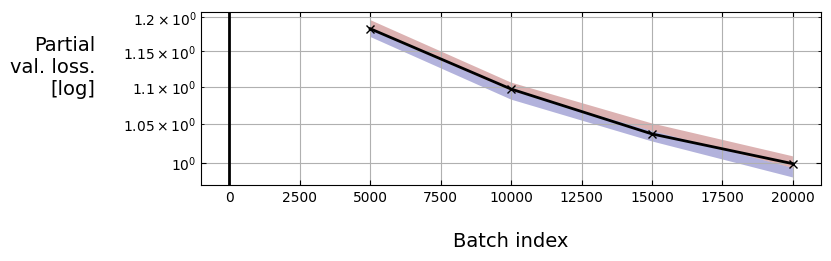

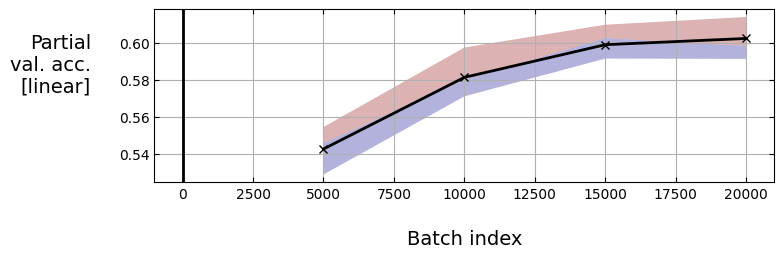

 39999/239761 [====>.........................] - ETA: 2:44:06 - loss: 1.0902 - masked_accuracy: 0.5771

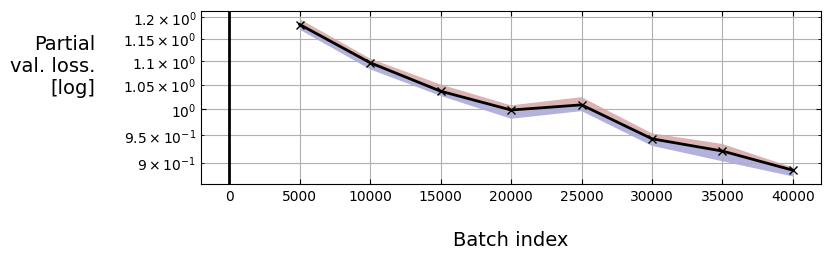

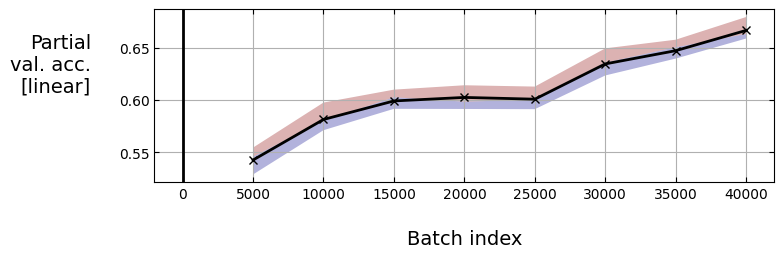

 59999/239761 [======>.......................] - ETA: 2:34:09 - loss: 1.0364 - masked_accuracy: 0.5944

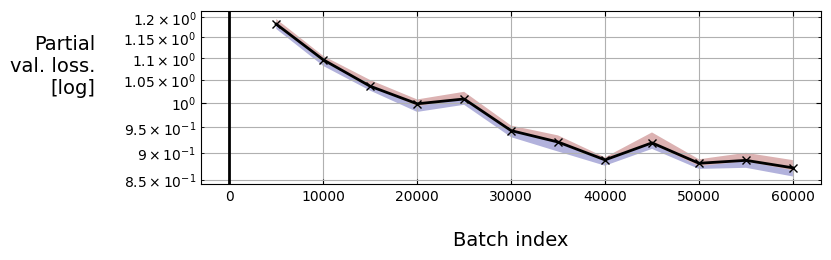

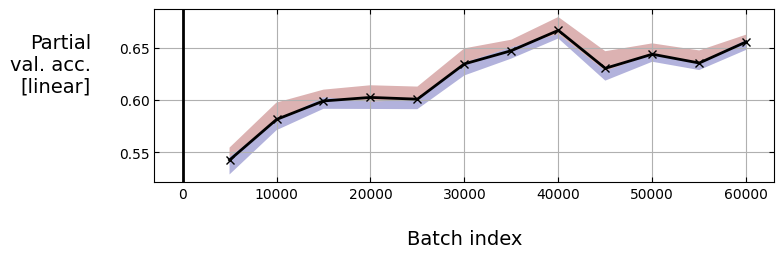

 79999/239761 [=========>....................] - ETA: 2:25:29 - loss: 1.0005 - masked_accuracy: 0.6061

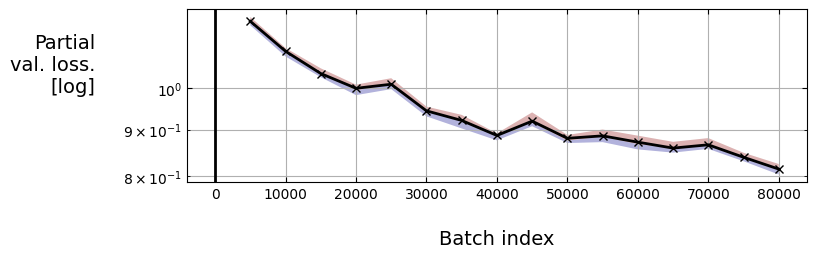

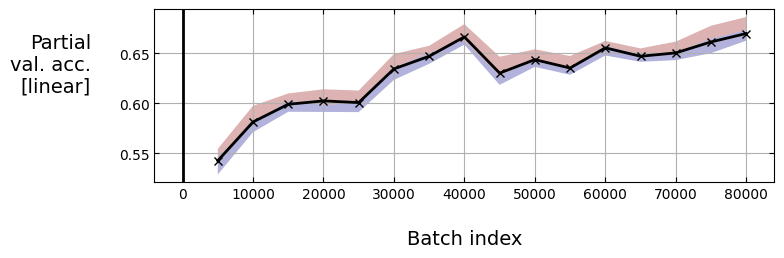

 99999/239761 [===========>..................] - ETA: 2:12:38 - loss: 0.9733 - masked_accuracy: 0.6152

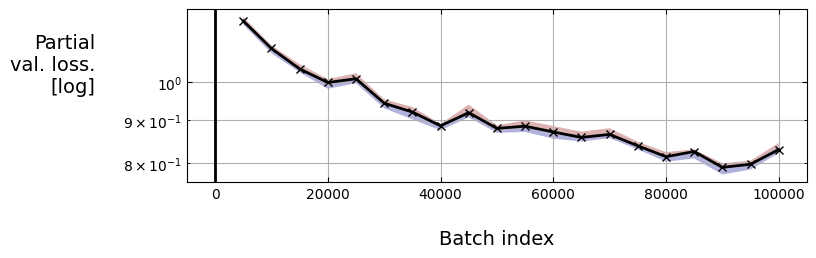

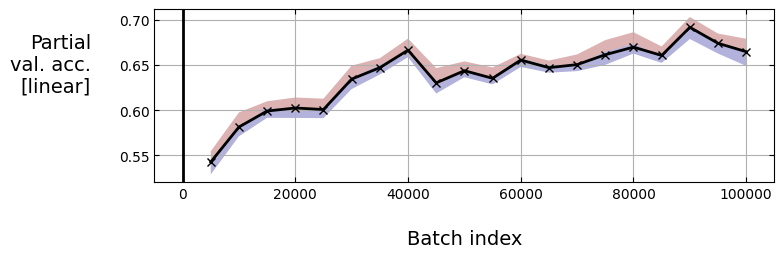

119999/239761 [==============>...............] - ETA: 1:56:40 - loss: 0.9420 - masked_accuracy: 0.6271

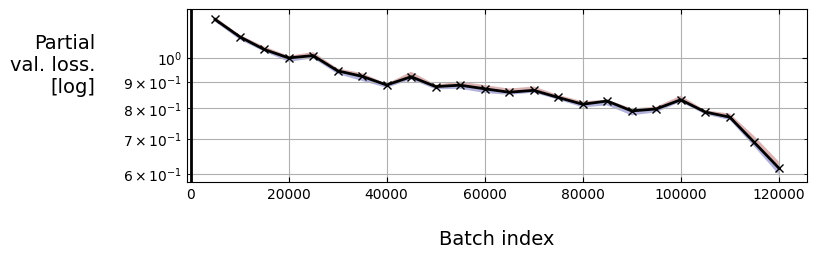

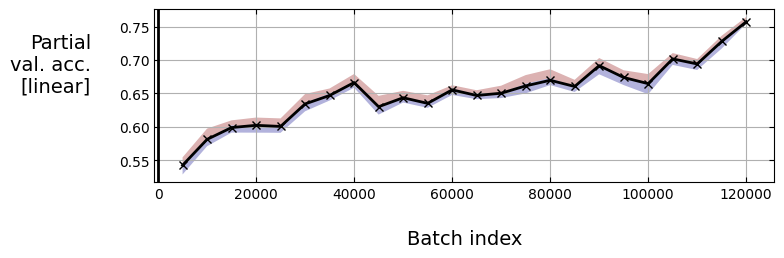

139999/239761 [================>.............] - ETA: 1:37:16 - loss: 0.8865 - masked_accuracy: 0.6494

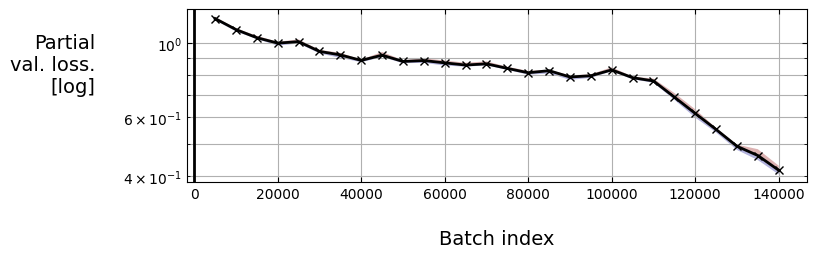

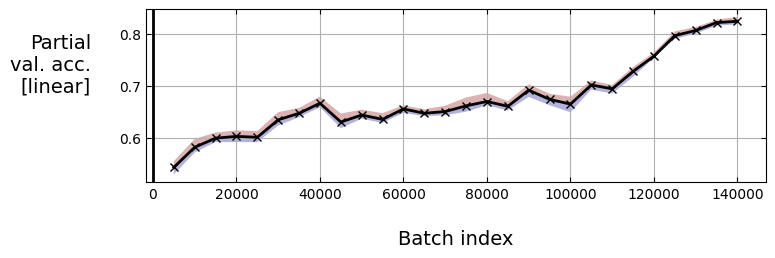

159999/239761 [===================>..........] - ETA: 1:18:01 - loss: 0.8253 - masked_accuracy: 0.6726

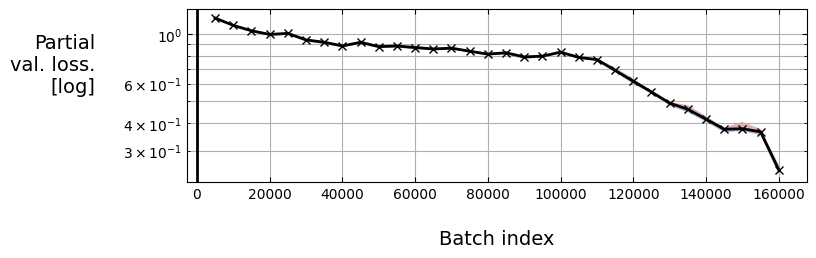

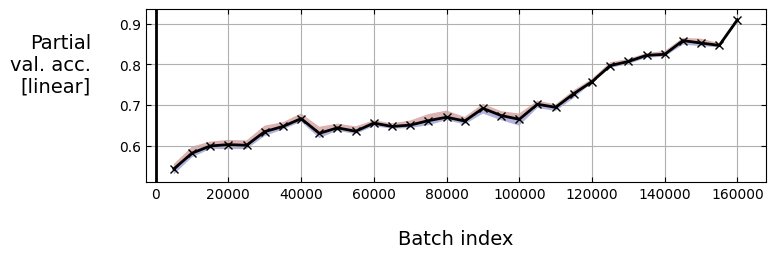

179999/239761 [=====================>........] - ETA: 58:11 - loss: 0.7517 - masked_accuracy: 0.7024

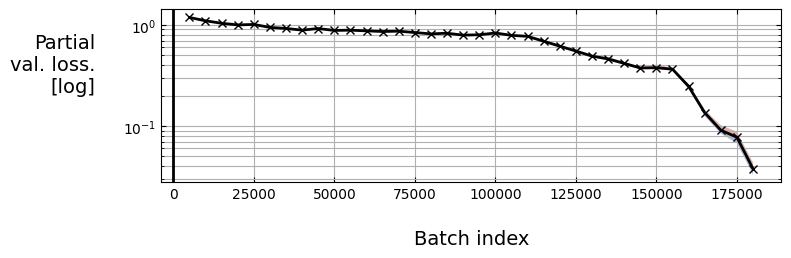

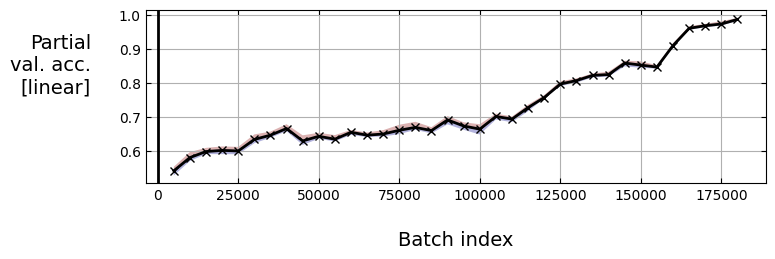

199999/239761 [========================>.....] - ETA: 38:22 - loss: 0.6842 - masked_accuracy: 0.7294

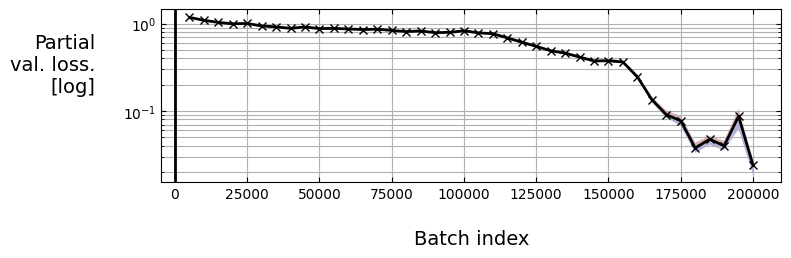

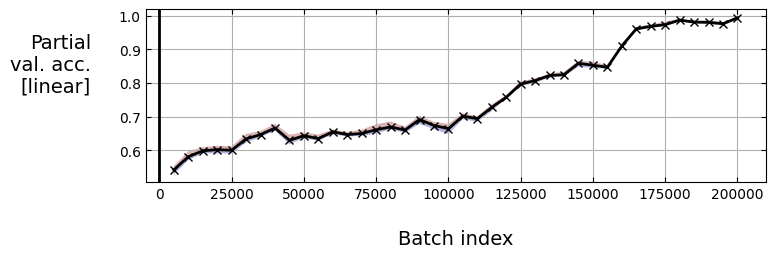

219999/239761 [==========================>...] - ETA: 18:54 - loss: 0.6264 - masked_accuracy: 0.7526

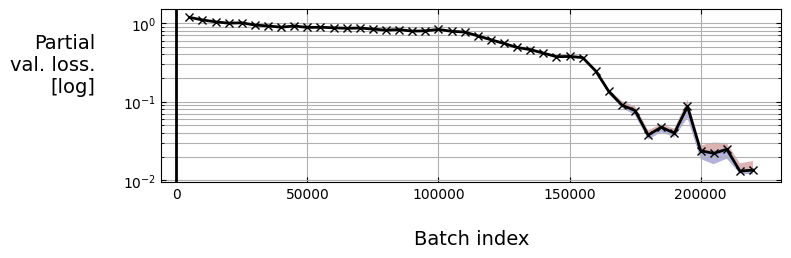

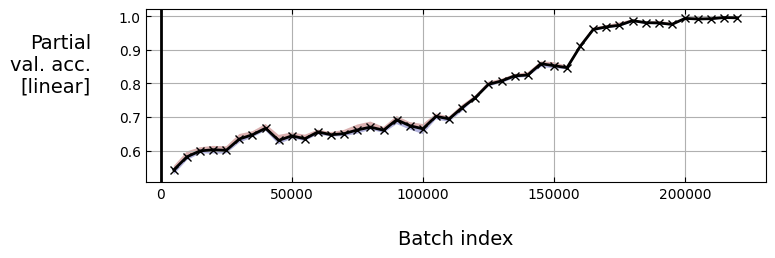

239761/239761 [==============================] - ETA: 0s - loss: 0.5775 - masked_accuracy: 0.7721

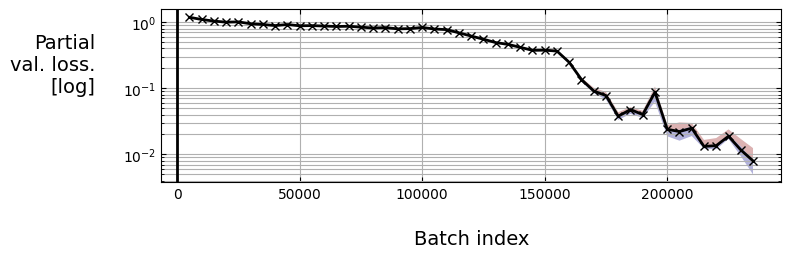

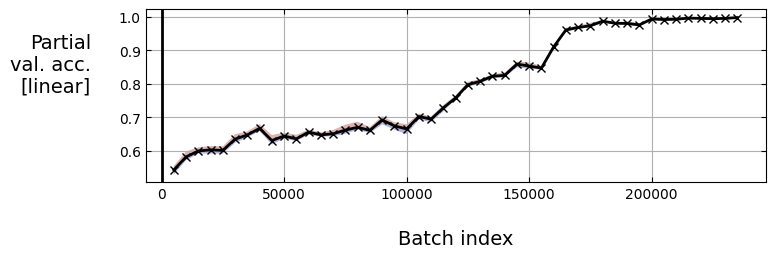

239761/239761 [==============================] - 13779s 57ms/step - loss: 0.5775 - masked_accuracy: 0.7721 - val_loss: 0.0110 - val_masked_accuracy: 0.9965
Epoch 2/10000
239760/239761 [============================>.] - ETA: 0s - loss: 0.0143 - masked_accuracy: 0.9957

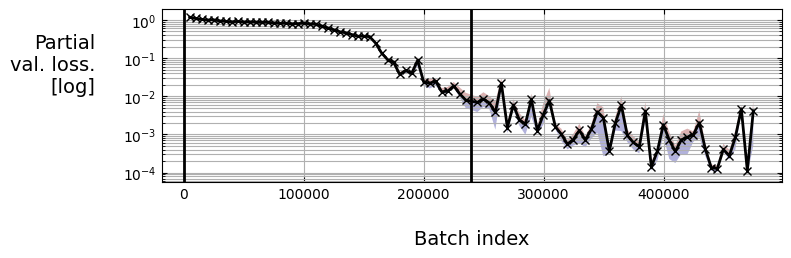

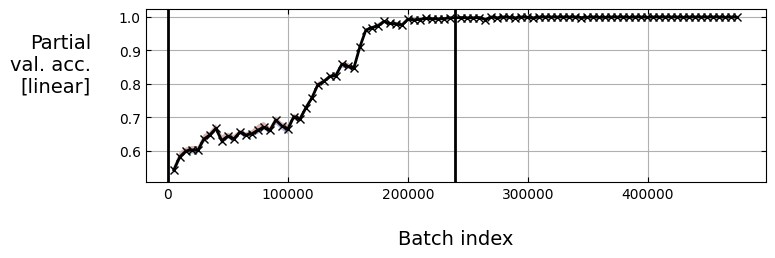

239761/239761 [==============================] - 13279s 55ms/step - loss: 0.0143 - masked_accuracy: 0.9957 - val_loss: 0.0019 - val_masked_accuracy: 0.9996
Epoch 3/10000
239759/239761 [============================>.] - ETA: 0s - loss: 0.0066 - masked_accuracy: 0.9981

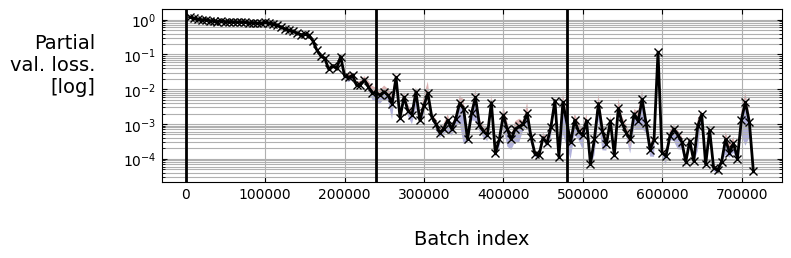

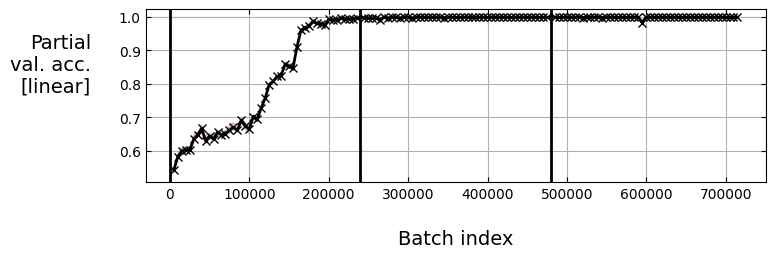

239761/239761 [==============================] - 12095s 50ms/step - loss: 0.0066 - masked_accuracy: 0.9981 - val_loss: 2.3003e-04 - val_masked_accuracy: 1.0000
Epoch 4/10000
  3890/239761 [..............................] - ETA: 2:36:28 - loss: 0.0059 - masked_accuracy: 0.9986

KeyboardInterrupt: 

In [13]:
##=================##
##   Train model   ##
##=================##


##  Fit the model if configured
if global_config.get("training",{}).get("train",True) :
    max_epochs = global_config["training"]["max_epochs"]
    batch_size = global_config["training"]["batch_size"]
    
    logger.info(f"Begin model training with max_epochs={max_epochs}, batch_size={batch_size}")
    model.fit([train_X, train_Y_in], 
              train_Y_out,
              epochs          = max_epochs,
              batch_size      = batch_size,
              validation_data = ([val_X, val_Y_in], val_Y_out),
              callbacks       = callbacks
             )
else :
    logger.warning("Skipping model training following global config instructions")


In [14]:
##================##
##   Save model   ##
##================##

if global_config.get("training",{}).get("train",True) :
    save_fname = f"{working_dir}/final_model.h5"
    model.save(save_fname)
    logger.info(f"Model save to file {save_fname}")
else :
    logger.warning("Not saving model because no training was done")


   INFO <module>: Model save to file unsupervised_learning_addition_model_baseline_2023_04_13_v2/final_model.h5


## 6.  Evaluate model

In [15]:
##====================================##
##   Evaluate model using test data   ##
##====================================##

##  Print values of metrics over the test set
logger.info(f"Evaluating text --> text mathsformer on the test set (size {len(test_X)}):")
test_metric_vals = model.evaluate([test_X, test_Y_in], test_Y_out)
for metric_name, metric_val in zip(model.metrics_names, test_metric_vals) :
    logger.info(f"    Metric {metric_name} with value {metric_val:.6}")

##  Find out how many datapoints to print predictions for 
num_print = int(global_config.get("evaluate",{}).get("num_print", 20))

##  Create transformer wrapper for model and token_transform
transformer = Transformer_Text_to_Text(model, token_transform)

##  Log table header
logger.info(f"Printing {num_print} examples:")
logger.info("-"*50)
logger.info("INPUT".rjust(12) + "TRUE".rjust(8) + "PRED".rjust(8) + "CORRECT".rjust(10) + "RESIDUAL".rjust(10))
logger.info("-"*50)

##  Get model predictions and log alongside true labels 
for x, x_str, true_y_str in zip(test_X[:num_print], 
                                transformer.token_transform.detokenise_strings(test_X    [:num_print,:].numpy()),
                                transformer.token_transform.detokenise_strings(test_Y_out[:num_print  ].numpy())) :
    pred_y_str = transformer.transform_from_data_tensor(x, max_tokens=20)
    result     = "  X" if pred_y_str == true_y_str else ""
    try    : residual = str(int(pred_y_str.replace("N","-")) - int(true_y_str.replace("N","-")))
    except : residual = "N/A"
    logger.info(x_str.rjust(12) + true_y_str.rjust(8) + pred_y_str.rjust(8) + result.rjust(8) + residual.rjust(10))


   INFO <module>: Evaluating text --> text mathsformer on the test set (size 159840):
4995/4995 [==============================] - 60s 12ms/step - loss: 6.0987e-04 - masked_accuracy: 0.9999
   INFO <module>:     Metric loss with value 0.000609874
   INFO <module>:     Metric masked_accuracy with value 0.999871
   INFO <module>: Printing 20 examples:
   INFO <module>: --------------------------------------------------
   INFO <module>:        INPUT    TRUE    PRED   CORRECT  RESIDUAL
   INFO <module>: --------------------------------------------------
   INFO <module>:     N837+N77    N914    N914       X         0
   INFO <module>:     N892-834   N1726   N1726       X         0
   INFO <module>:    N393+N629   N1022   N1022       X         0
   INFO <module>:    N872-N824     N48     N48       X         0
   INFO <module>:      588+447    1035    1035       X         0
   INFO <module>:       54-953    N899    N899       X         0
   INFO <module>:     894-N300    1194    1194       

In [16]:
##======================================================================================##
##   Evaluate model using random numbers with lengths not experienced during training   ##
##======================================================================================##

##  Find out the maximum number of digits to allow per input number (= 2 higher than maximum input length)
max_char = math.floor(math.log10(global_config["data"]["max_int"])) + 2

##  Log table header
logger.info(f"Evaluating text --> text mathsformer on randomly generated strings with max number length of {max_char}:")
logger.info("-"*70)
logger.info("INPUT".rjust(15) + "TRUE".rjust(15) + "PRED".rjust(15) + "RESIDUAL".rjust(15))
logger.info("-"*70)

for i in range(num_print) :
    m1, m2 = np.random.randint(low=1, high=max_char+1, size=(2,))
    n1, n2 = np.random.randint(low=10**(m1-1), high=10**m1), np.random.randint(low=10**(m2-1), high=10**m2)
    s1, s2 = np.random.choice([-1, 1], size=(2,))
    n1, n2 = s1*n1, s2*n2
    s1, s2 = str(n1).replace("-","N"), str(n2).replace("-","N")
    op = np.random.choice(["+", "-"])
    if op == "+" : answer = n1 + n2
    if op == "-" : answer = n1 - n2
    query = f"{s1}{op}{s2}"
    guess = transformer.transform_from_string(query).replace("N","-")
    try : residual = str(int(guess) - answer)
    except : residual = "N/A"
    logger.info(query.rjust(15) + str(answer).rjust(15) + guess.rjust(15) + residual.rjust(15))



   INFO <module>: Evaluating text --> text mathsformer on randomly generated strings with max number length of 4:
   INFO <module>: ----------------------------------------------------------------------
   INFO <module>:           INPUT           TRUE           PRED       RESIDUAL
   INFO <module>: ----------------------------------------------------------------------
   INFO <module>:          17+N56            -39            -39              0
   INFO <module>:       N9951-N82          -9869           -813           9056
   INFO <module>:       5869+N746           5123           -223          -5346
   INFO <module>:          34+809            843            843              0
   INFO <module>:        N43-4636          -4679           -579           4100
   INFO <module>:          5446+6           5452           -540          -5992
   INFO <module>:          7+N667           -660           -660              0
   INFO <module>:          145+85            230            230             

##  7. Additional visualisations

   INFO <module>: Plotting layer weights


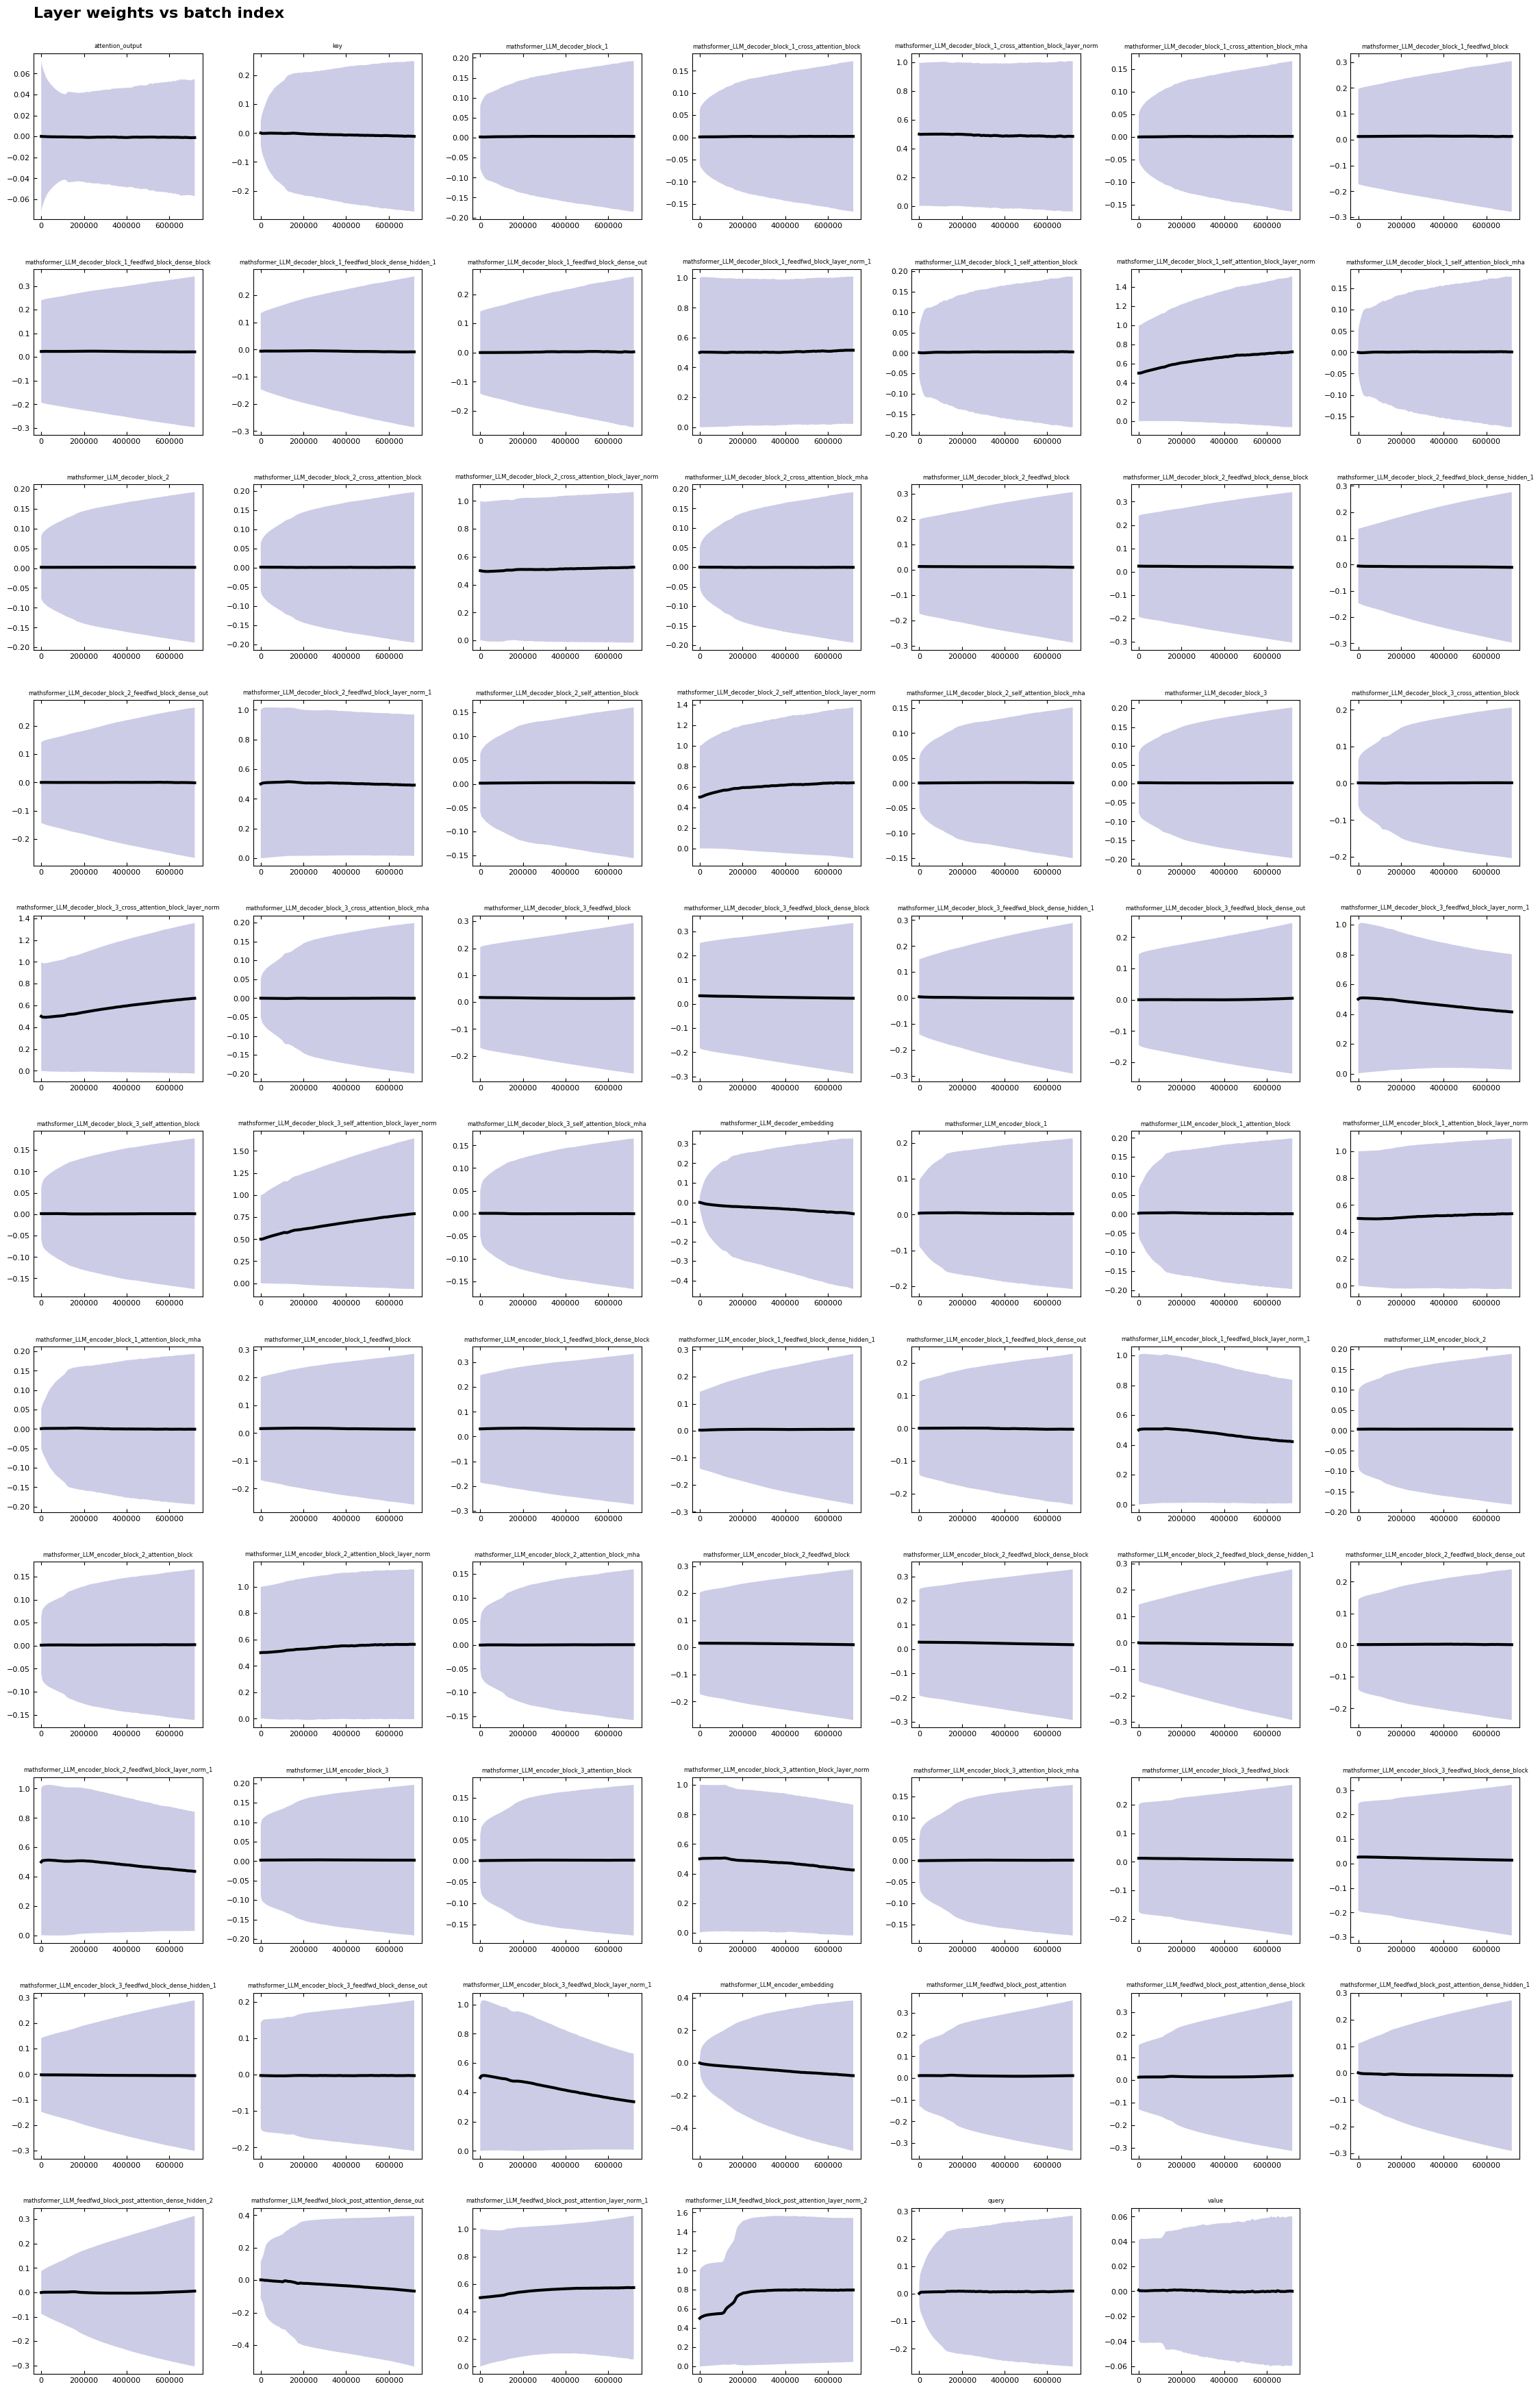

In [17]:
##=============================================##
##   Visualise layer weights during training   ##
##=============================================##

if len(layer_weights_record.batch_indices) == 0 :
    logger.warning("Not plotting layer weights because no data found")
else :
    logger.info("Plotting layer weights")
    layer_weights_record.plot(num_col=7)
    